In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 楕円データと真値パラメータの読み込み
ellipse_points = [] # 点の座標
true_param = [] # パラメータの真値
with open('points.dat') as f:
    content = f.readlines()
    for line in content:
        line_list = line.split()
        ellipse_points.append((float(line_list[0]), float(line_list[1]))) # (X, Y)
with open('true_param.dat') as f:
    content = f.readlines()
    for line in content:
        true_param.append(float(line))

In [3]:
# 座標列と定数f0からξを求める
def calc_xi(points, f0):
    xi = []
    for p in points:
        a = p[0] * p[0]
        b = 2 * p[0] * p[1]
        c = p[1] * p[1]
        d = 2 * f0 * p[0]
        e = 2 * f0 * p[1]
        f = f0 * f0
        xi.append(np.array([[a, b, c, d, e, f]]).T)
    return xi

In [4]:
# 座標列と定数f0から各座標のV[ξ_α]を求める
def calc_V_xi(points, f0):
    V_xi = []
    for p in points:
        x = p[0]
        y = p[1]
        V_xi.append(4 * np.array([[ x * x,         x * y,      0,  f0 * x,       0, 0],
                                  [ x * y, x * x + y * y,  x * y,  f0 * y,  f0 * x, 0],
                                  [     0,         x * y,  y * y,       0,  f0 * y, 0],
                                  [f0 * x,        f0 * y,      0, f0 * f0,       0, 0],
                                  [     0,        f0 * x, f0 * y,       0, f0 * f0, 0],
                                  [     0,             0,      0,       0,       0, 0]]))
    return V_xi

In [5]:
# 最小二乗法
def least_square(points, f0 = 600):
    xi = calc_xi(points, f0)
    M = np.zeros([len(xi[0]), len(xi[0])])
    for xi_a in xi:
        M += np.dot(xi_a, xi_a.T)
    e_val, e_vec = np.linalg.eig(M)
    smallest_idx = e_val.argmin()
    smallest_vec = e_vec[:, smallest_idx]
    return smallest_vec / np.linalg.norm(smallest_vec)

In [6]:
# FNS法による最尤推定
def maximum_likelihood(points, f0 = 600):
    u = np.array(least_square(points, f0)) # 初期値
    xi = calc_xi(points, f0)
    V_xi = calc_V_xi(points, f0)
    diff = 1.0
    EPS = 1e-9
    iter_limit = 100
    iter_count = 0
    while diff > EPS:
        M = np.zeros([len(xi[0]), len(xi[0])])
        L = np.zeros([len(xi[0]), len(xi[0])])
        for a, xi_a in enumerate(xi):
            prod_u_xi = np.dot(u, xi_a)
            div = np.dot(u, np.dot(V_xi[a], u))
            M += np.dot(xi_a, xi_a.T) / div
            L += prod_u_xi * prod_u_xi * V_xi[a] / div / div
        e_val, e_vec = np.linalg.eig(M)
        smallest_idx = e_val.argmin()
        smallest_vec = e_vec[:, smallest_idx] / np.linalg.norm(e_vec[:, smallest_idx])
        diff = min(np.linalg.norm(smallest_vec - u), np.linalg.norm(smallest_vec + u))
        u = smallest_vec
        iter_count += 1
        if iter_count > iter_limit: break
    return u

In [7]:
# 誤差を求める
def calc_diff(params, true_param = true_param, f0 = 600):
    u = np.array([true_param]).T
    p = np.identity(len(true_param)) - np.dot(u, u.T)
    diff = np.linalg.norm(np.dot(p, params))
    return diff

In [8]:
# 指定した分散の指定した方法による平方平均二乗誤差を求める
def calc_range_rms(spread, samples, method):
    total = 0.0
    for i in range(samples):
        noisy_ellipse_points = []
        for point in ellipse_points:
            noisy_ellipse_points.append((point[0] + np.random.normal(scale=spread), point[1] + np.random.normal(scale=spread)))
        param = method(noisy_ellipse_points, 600)
        total += calc_diff(param) ** 2
    e = np.sqrt(total / samples)
    return e

In [9]:
# σ=[0, 1]の範囲を、0.001ずつ変化させながらそれぞれ1000回試行して、平方平均二乗誤差を求める
# 時間がかかるので並列化
from joblib import Parallel, delayed

start = 0
end = 1
delta = 0.001
samples = 1000

x = np.linspace(start, end, int((end - start) / delta) + 1)
y_ls = Parallel(n_jobs=-1, verbose=10)([delayed(calc_range_rms)(spread, samples, least_square) for spread in x])
y_ml = Parallel(n_jobs=-1, verbose=10)([delayed(calc_range_rms)(spread, samples, maximum_likelihood) for spread in x])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

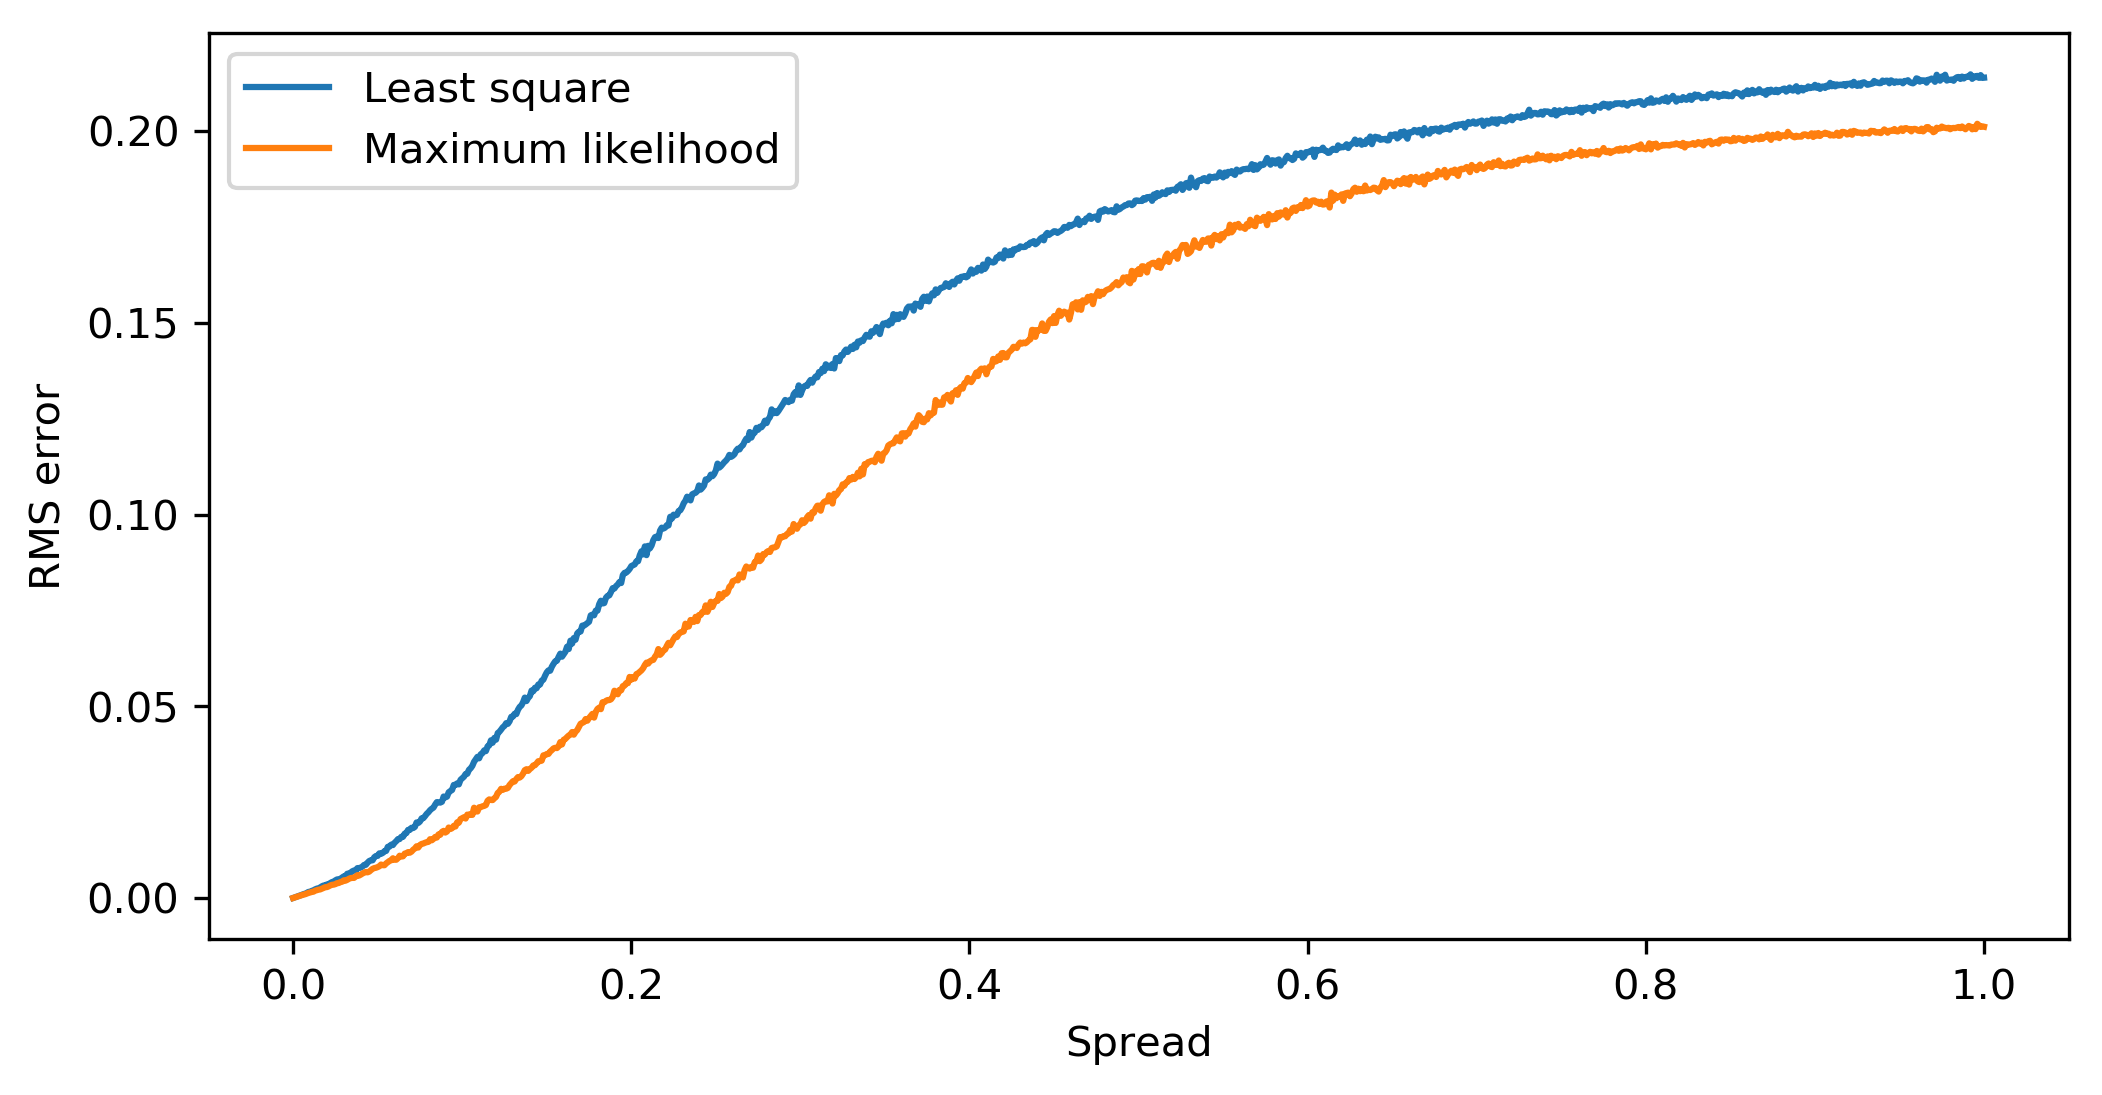

In [10]:
f = plt.figure(figsize=(8, 4), dpi=300)
f.add_subplot(1, 1, 1)
plt.plot(x, y_ls, label='Least square')
plt.plot(x, y_ml, label='Maximum likelihood')
plt.xlabel('Spread')
plt.ylabel('RMS error')
plt.legend()
plt.savefig('error_comparison.png')
plt.show()

In [11]:
# 参考: http://daily-tech.hatenablog.com/entry/2018/04/13/084734

from sympy import *
import sympy
import numpy as np
import matplotlib.pyplot as plt
import math

def generateVecFromEllipse(axis, center, T, rng=[0, 2*math.pi], num=1001):
 
  t = np.linspace(rng[0], rng[1], num) 
  t = np.reshape(t, (t.shape[0], 1))
  
  xVec = np.zeros((t.shape))
  yVec = np.zeros((t.shape))
  for i in range(t.shape[0]):
    xVec[i] = axis[0, 0] * math.cos(t[i])
    yVec[i] = axis[1, 0] * math.sin(t[i])
  
  dataTmp = np.concatenate((xVec, yVec),  axis=1)
  dataTmp = T * dataTmp.T
  dataTmp = dataTmp.T
  dataTmp[:, 0] =  dataTmp[:, 0] + center[0, 0]
  dataTmp[:, 1] =  dataTmp[:, 1] + center[1, 0]
  
  return dataTmp
  
def getEllipseProperty(A, B, C, D, E, F):
  
  if A < 0:
    A = -A
    B = -B
    C = -C
    D = -D
    E = -E
    F = -F   
    
  # Spectral Decomposition
  M = np.matrix([[A, B/2], [B/2, C]])
  lamdas, v = np.linalg.eigh(M)
  
  # Diagonalize Coeffs Matrix
  DiagA = v.T * M * v  
  
  # Apply translation for 1st order term.
  tmp = np.matrix([D, E]) * v
                  
  # Calculate coefficient in rotated coords
  AA = DiagA[0, 0]
  BA = DiagA[0, 1] + DiagA[1, 0]
  CA = DiagA[1, 1]
  DA = tmp[0, 0]
  EA = tmp[0, 1]
  scale = F - DA**2 / (4*AA) - EA**2 / (4*CA)
  
  # Normalize coeffs wrt to constant term.
  AA = AA / abs(scale)
  BA = BA / abs(scale)
  CA = CA / abs(scale)
  DA = DA / abs(scale)
  EA = EA / abs(scale)
  FA = abs(scale) / abs(scale)
 
  # Ellipse Property Extraction
  a = 1 / math.sqrt(abs(lamdas[0] / scale))
  b = 1 / math.sqrt(abs(lamdas[1] / scale))
  
  T = np.matrix([[v[0, 0], v[0, 1]], [v[1, 0], v[1, 1]]]) 
  trans = v.T * np.matrix([[-DA/(2*AA)], [-EA/(2*CA)]])
 
  valid = True
  if AA * CA < 0:
    valid = False
  
  return valid, np.matrix([[a], [b]]), trans, T

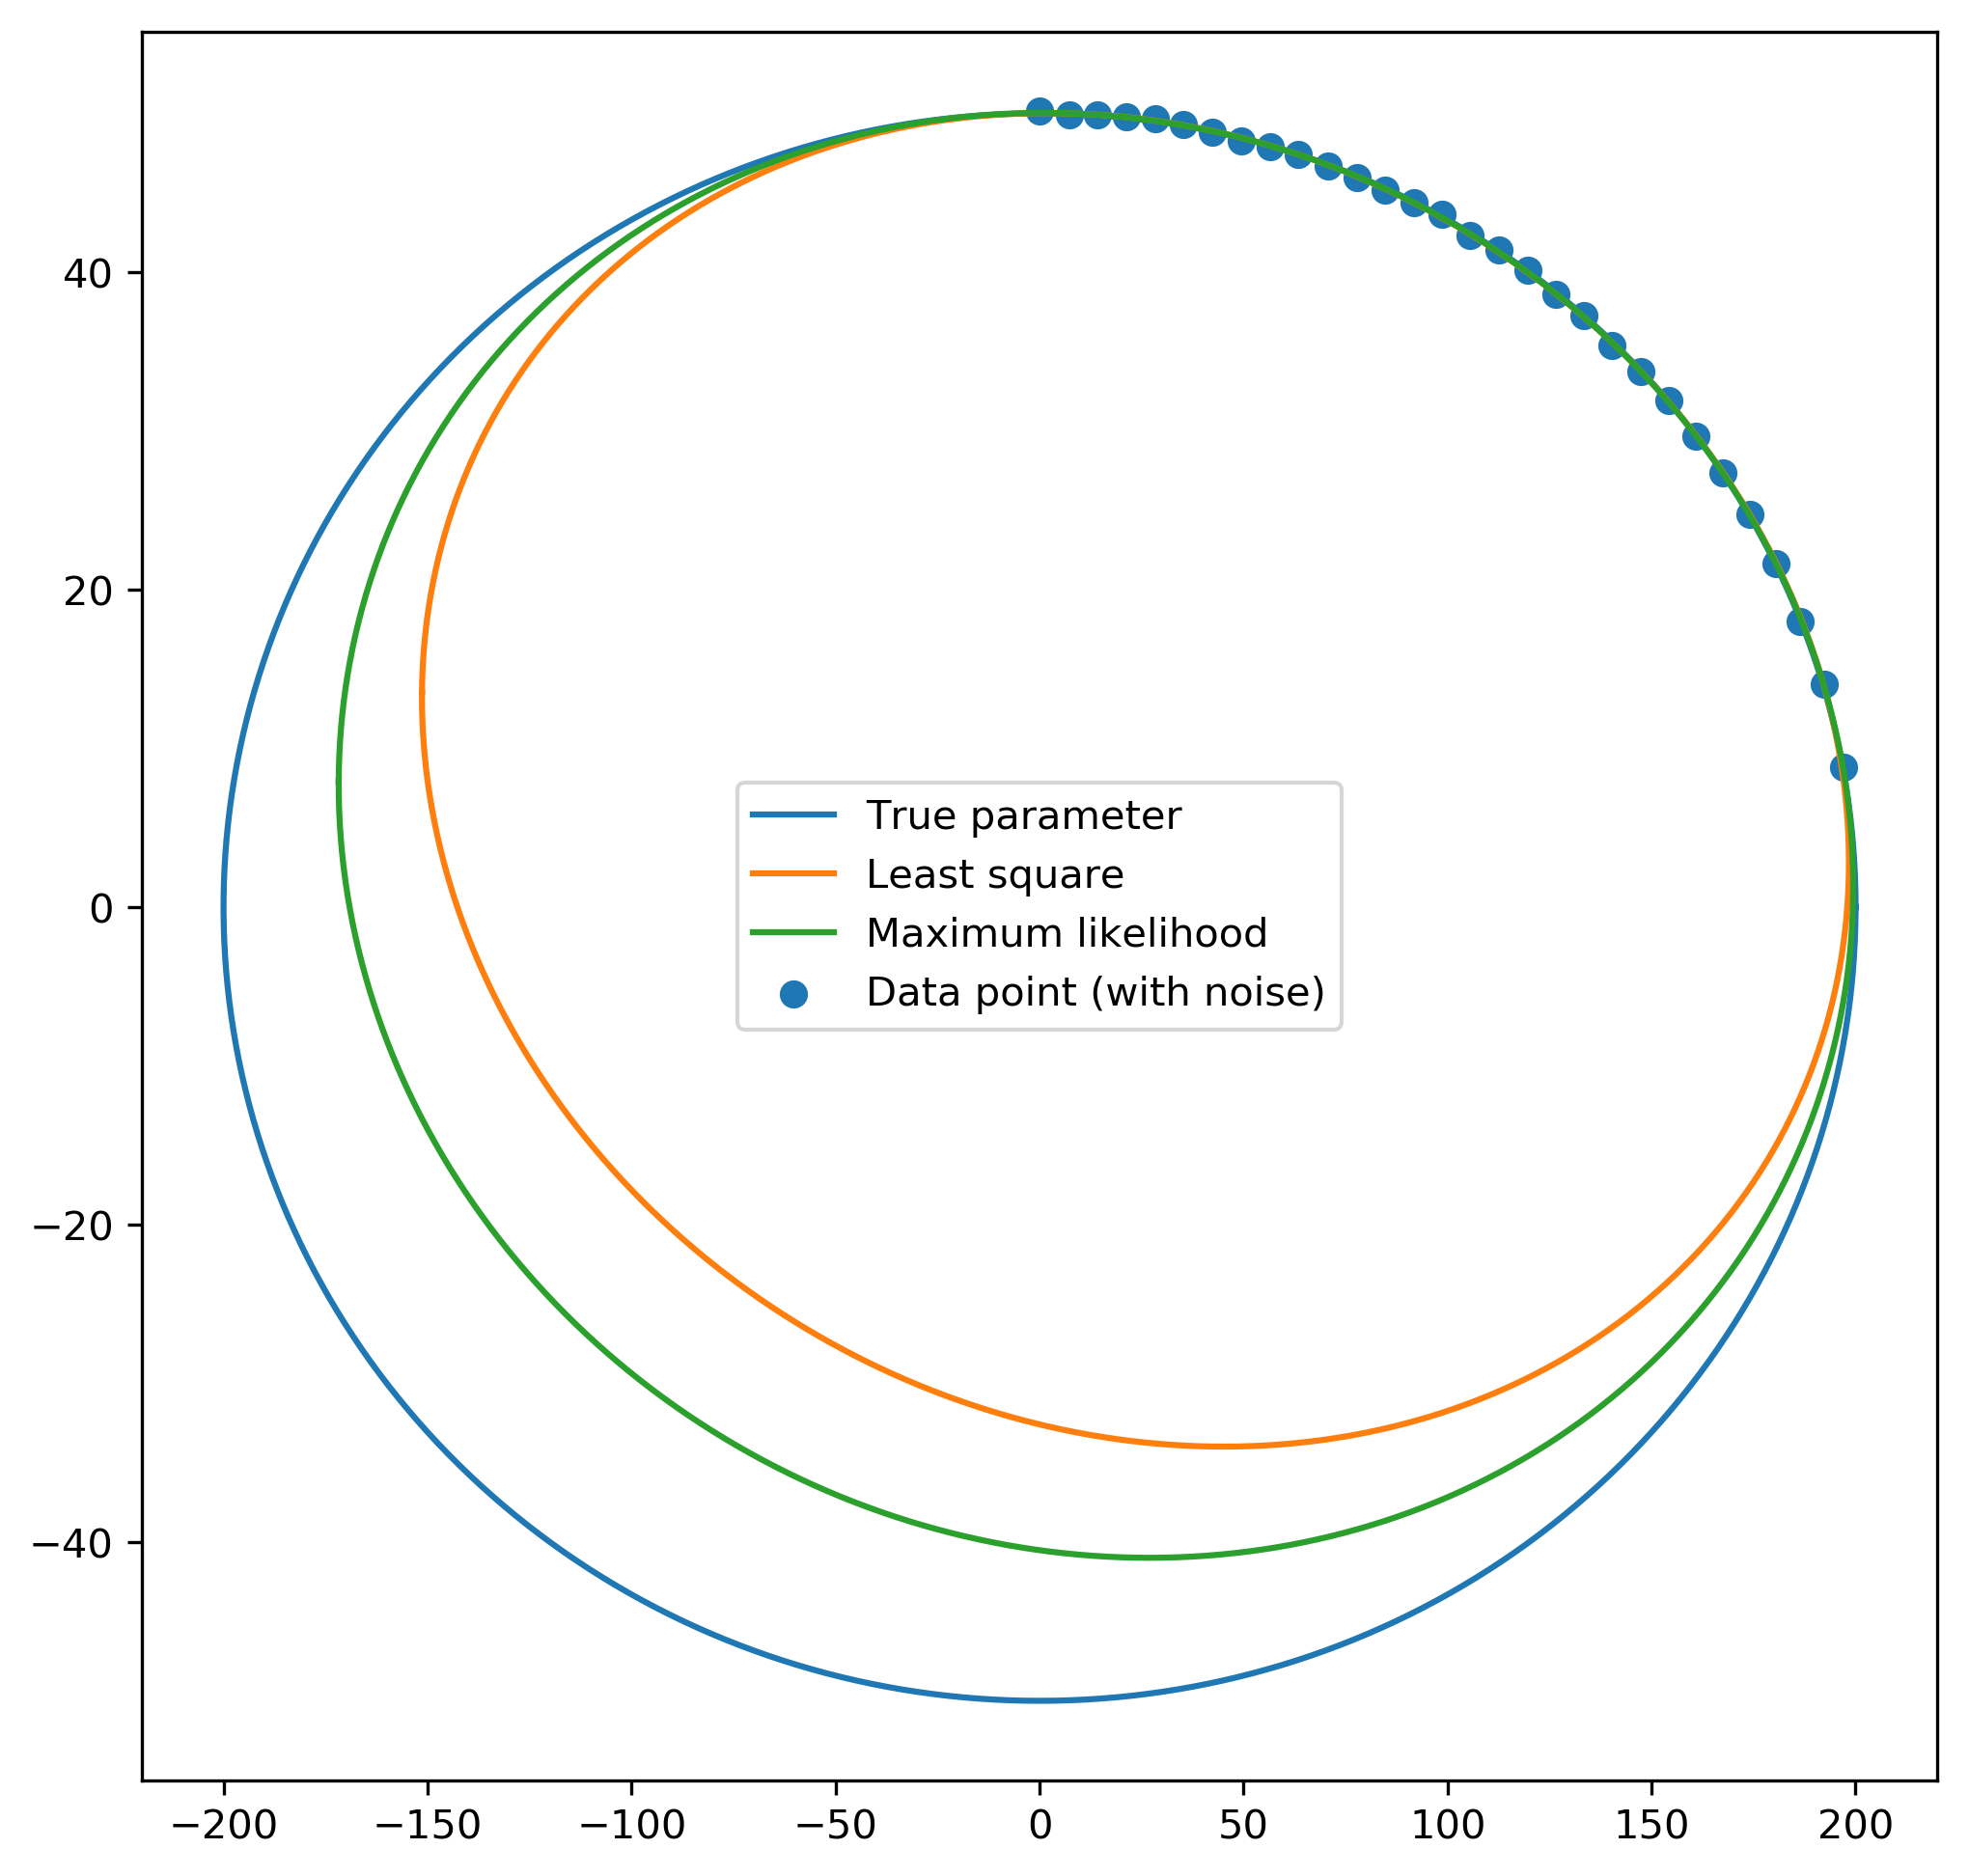

In [12]:
# 楕円のグラフを描画

noisy_ellipse_points = []
for point in ellipse_points:
    noisy_ellipse_points.append((point[0] + np.random.normal(scale=0.1), point[1] + np.random.normal(scale=0.1)))
f0 = 600
param_ls = least_square(noisy_ellipse_points, f0)
param_ml = maximum_likelihood(noisy_ellipse_points, f0)
valid_tr, axis_tr, centerEst_tr, Rest_tr = getEllipseProperty(true_param[0], 2 * true_param[1], true_param[2], 2 * f0 * true_param[3], 2 * f0 * true_param[4], f0 * f0 * true_param[5])
valid_ls, axis_ls, centerEst_ls, Rest_ls = getEllipseProperty(param_ls[0], 2 * param_ls[1], param_ls[2], 2 * f0 * param_ls[3], 2 * f0 * param_ls[4], f0 * f0 * param_ls[5])
valid_ml, axis_ml, centerEst_ml, Rest_ml = getEllipseProperty(param_ml[0], 2 * param_ml[1], param_ml[2], 2 * f0 * param_ml[3], 2 * f0 * param_ml[4], f0 * f0 * param_ml[5])
dataEst_tr = generateVecFromEllipse(axis_tr, centerEst_tr, Rest_tr)
dataEst_ls = generateVecFromEllipse(axis_ls, centerEst_ls, Rest_ls)
dataEst_ml = generateVecFromEllipse(axis_ml, centerEst_ml, Rest_ml)
f = plt.figure(figsize=(8, 8), dpi=300)
f.add_subplot(1, 1, 1)
plt.scatter(np.array(noisy_ellipse_points)[:, 0].tolist(), np.array(noisy_ellipse_points)[:, 1].tolist(), label='Data point (with noise)')
plt.plot(dataEst_tr[:, 0], dataEst_tr[:, 1], label='True parameter')
plt.plot(dataEst_ls[:, 0], dataEst_ls[:, 1], label='Least square')
plt.plot(dataEst_ml[:, 0], dataEst_ml[:, 1], label='Maximum likelihood')
plt.legend()
plt.savefig('ellipse_comparison.png')
plt.show()